# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from skimage import exposure
from skimage.restoration import denoise_bilateral
from sklearn.decomposition import PCA

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from torchvision import datasets

## **Configurazione**

In [2]:
@dataclass
class Config:
    # paths
    fit_dir  = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid"
    #fit_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/valid"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test_degradato"
    
    img_size = 128   # per HOG spesso 128 va benissimo
    random_state = 42 # tuning
    max_iter = 50000 # tuning
    
def sanity_check_paths(cfg: Config):
    for p in [cfg.fit_dir, cfg.test_dir]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Path not found: {p}")
    print("OK paths")
    print("fit_dir:", cfg.fit_dir)
    print("test_dir:", cfg.test_dir)

## **Feature Extraction**

In [3]:
def preprocess_gray(img_gray, mode: str):
    # mode: "none", "clahe", "gamma", "bilat_clahe"
    if mode == "none":
        return img_gray

    x = img_gray.astype(np.float32) / 255.0

    if mode == "gamma":
        gamma = 0.8
        x = np.power(x, gamma)

    elif mode == "clahe":
        x = exposure.equalize_adapthist(x, clip_limit=0.005)

    elif mode == "bilat_clahe":
        x = denoise_bilateral(x, sigma_color=0.05, sigma_spatial=2, channel_axis=None)
        x = exposure.equalize_adapthist(x, clip_limit=0.01)

    x = np.clip(x, 0, 1)
    return (x * 255).astype(np.uint8)



def extract_hog(path, cfg, hog_conf, pre_mode):
    img = Image.open(path).convert("RGB")
    img = img.resize((cfg.img_size, cfg.img_size))
    gray = np.array(img.convert("L"))
    gray = preprocess_gray(gray, pre_mode)

    return hog(
        gray,
        orientations=hog_conf["orient"],
        pixels_per_cell=hog_conf["ppc"],
        cells_per_block=hog_conf["cpb"],
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)

def extract_lbp_hist(gray: np.ndarray, P: int, R: int) -> np.ndarray:
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    n_bins = P + 2  # uniform => P+2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    return hist

def hog_on_patch(patch: np.ndarray, hog_conf: Dict[str, Any]) -> np.ndarray:
    return hog(
        patch,
        orientations=hog_conf["orient"],
        pixels_per_cell=hog_conf["ppc"],
        cells_per_block=hog_conf["cpb"],
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)


def extract_hog_pyramid(gray: np.ndarray, hog_conf: Dict[str, Any]) -> np.ndarray:
    """
    Pyramid: 1x1 + 2x2
    """
    feats = []

    H, W = gray.shape

    # level 1x1
    feats.append(hog_on_patch(gray, hog_conf))

    # level 2x2
    h2, w2 = H // 2, W // 2
    patches = [
        gray[0:h2,   0:w2],   # top-left
        gray[0:h2,   w2:W],   # top-right
        gray[h2:H,   0:w2],   # bottom-left
        gray[h2:H,   w2:W],   # bottom-right
    ]
    for p in patches:
        feats.append(hog_on_patch(p, hog_conf))

    return np.concatenate(feats, axis=0).astype(np.float32)

In [4]:
def extract_feature(path: str, cfg: Config, hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> np.ndarray:
    img = Image.open(path).convert("RGB").resize((cfg.img_size, cfg.img_size))
    gray = np.array(img.convert("L"))

    hog_pyr = extract_hog_pyramid(gray, hog_conf)
    lbp_hist = extract_lbp_hist(gray, P=lbp_conf["P"], R=lbp_conf["R"])

    return np.concatenate([hog_pyr, lbp_hist], axis=0).astype(np.float32)


def build_xy(folder, cfg: Config, hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for path, label in folder.samples:
        X.append(extract_feature(path, cfg, hog_conf, lbp_conf))
        y.append(label)
    return np.array(X), np.array(y)

## **Utils**

In [5]:
def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 30):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")


def plot_cm(cm: np.ndarray, title: str):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def build_model(C: float, pca_n: int = 480, solver: str = "saga", class_weight=None) -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_n, random_state=42)),
        ("clf", LogisticRegression(
            max_iter=20000,
            C=C,
            solver=solver,
            n_jobs=-1,
            class_weight=class_weight
        ))
    ])

## **Migliori configurazioni**

In [ ]:
# Base: prendo migliore: HOG orient=16 + LBP P32 R4
HOG_CONF = dict(orient=16, ppc=(16, 16), cpb=(2, 2))
LBP_CONF = dict(P=32, R=4)

BEST_CONFIGS = [
    dict(tag="PCA480 C=8  lbfgs",   C=8.0,  solver="lbfgs", class_weight=None),
    dict(tag="PCA480 C=8  saga",    C=8.0,  solver="saga",  class_weight=None),
    dict(tag="PCA480 C=8  saga+bal",C=8.0,  solver="saga",  class_weight="balanced"),
    dict(tag="PCA480 C=10 saga+bal",C=10.0, solver="saga",  class_weight="balanced"),
]


## **Main**

In [7]:
cfg = Config()
np.random.seed(cfg.random_state)
sanity_check_paths(cfg)

OK paths
fit_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid
test_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato


In [8]:
fit_ds  = datasets.ImageFolder(cfg.fit_dir)
test_ds = datasets.ImageFolder(cfg.test_dir)

assert fit_ds.classes == test_ds.classes, "Class order diverso tra fit e test!"
class_names = fit_ds.classes

print("Num classes:", len(class_names))
print("Fit samples:", len(fit_ds))
print("Test samples:", len(test_ds))

Num classes: 100
Fit samples: 500
Test samples: 500


In [ ]:
# estrazione feature UNA SOLA VOLTA 
print("\n[FEATURE] Estrazione feature (fit)...")
X_fit, y_fit = build_xy(fit_ds, cfg, HOG_CONF, LBP_CONF)

print("[FEATURE] Estrazione feature (test)...")
X_test, y_test = build_xy(test_ds, cfg, HOG_CONF, LBP_CONF)

print("X_fit shape:", X_fit.shape, " | X_test shape:", X_test.shape)


[FEATURE] Estrazione feature (fit)...
[FEATURE] Estrazione feature (test)...
X_fit shape: (500, 5474)  | X_test shape: (500, 5474)


In [10]:
all_results = {}
cms = {}

for conf in BEST_CONFIGS:
    print("\n" + "="*60)
    print(f"RUN: {conf['tag']}")
    print("="*60)

    model = build_model(
        C=conf["C"],
        pca_n=480,
        solver=conf["solver"],
        class_weight=conf["class_weight"]
    )

    model.fit(X_fit, y_fit)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro", zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro-F1:  {f1:.4f}")

    all_results[conf["tag"]] = {"acc": acc, "f1": f1, "C": conf["C"]}
    cms[conf["tag"]] = cm


RUN: PCA480 C=8  lbfgs
Accuracy:  0.1940
Macro-F1:  0.1876

RUN: PCA480 C=8  saga
Accuracy:  0.1860
Macro-F1:  0.1804

RUN: PCA480 C=8  saga+bal
Accuracy:  0.1860
Macro-F1:  0.1809

RUN: PCA480 C=10 saga+bal
Accuracy:  0.1860
Macro-F1:  0.1798


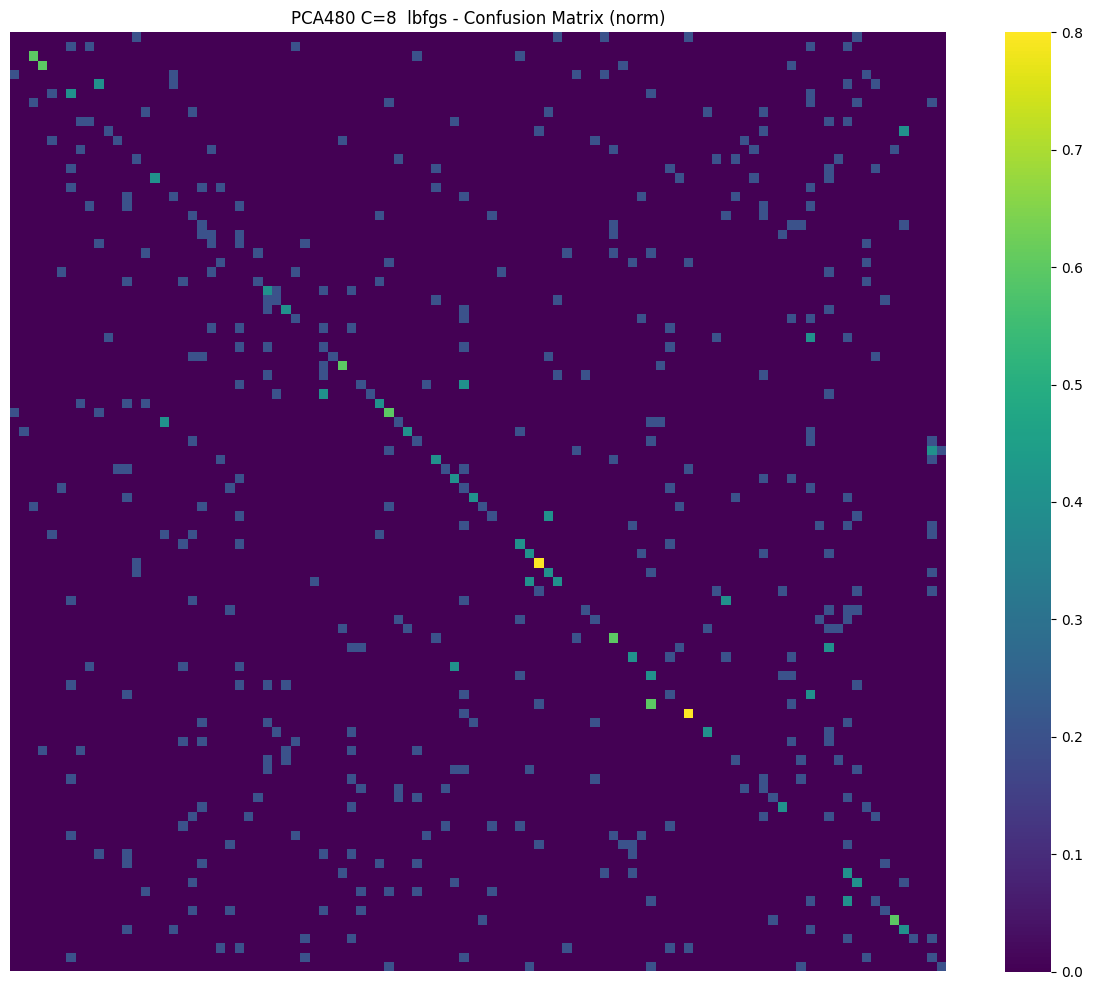


=== Top confusions: PCA480 C=8  lbfgs ===

Top 30 coppie più confuse:

rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
bike polo → water polo  | 2 errori
formula 1 racing → swimming  | 2 errori
hammer throw → ice yachting  | 2 errori
hang gliding → frisbee  | 2 errori
hockey → bull riding  | 2 errori
horseshoe pitching → wheelchair racing  | 2 errori
jousting → mushing  | 2 errori
nascar racing → luge  | 2 errori
parallel bar → ski jumping  | 2 errori
pommel horse → tennis  | 2 errori
rock climbing → ice climbing  | 2 errori
rowing → swimming  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → bobsled  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → basketball  | 1 errori
ampute football → fly fishing  | 1 errori
ampute football → swimming  | 1 errori
ampute football → trapeze 

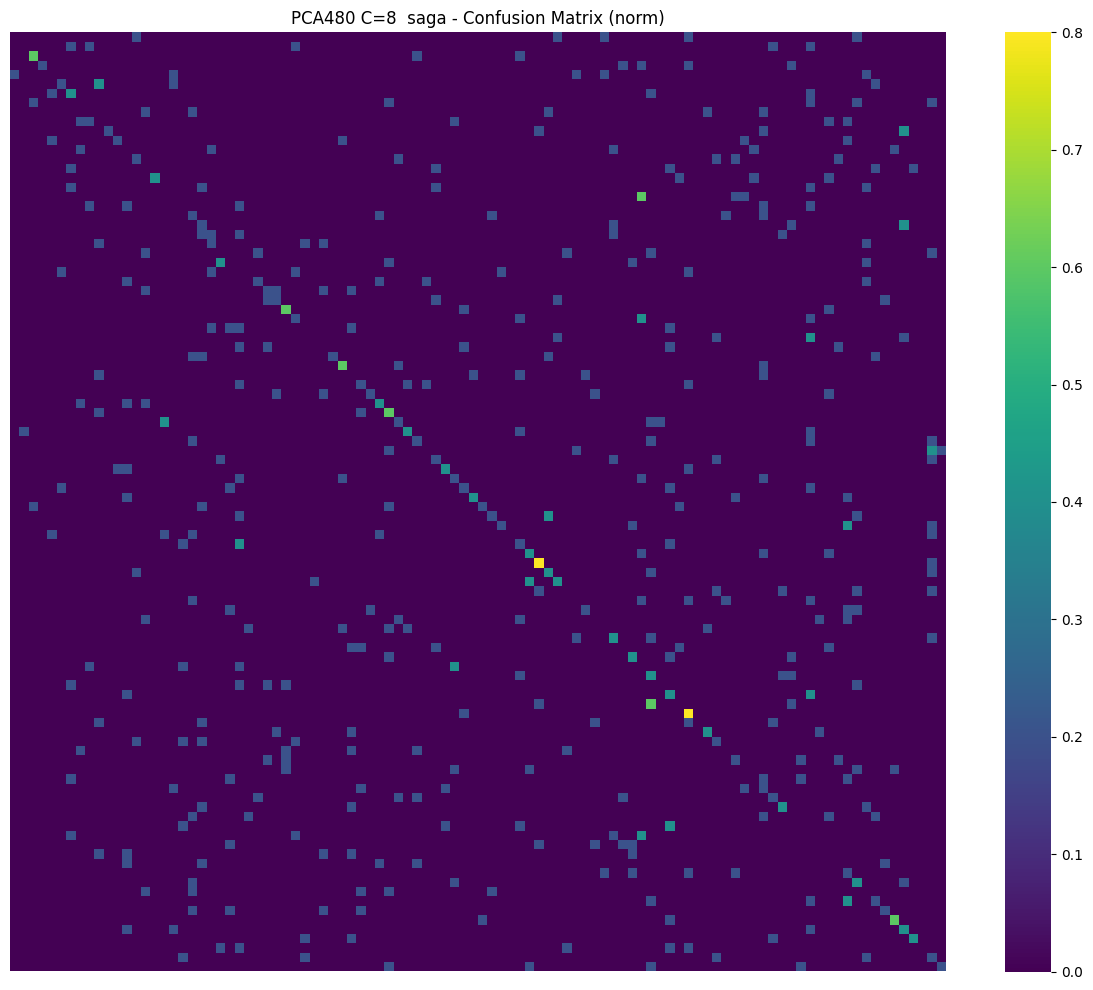


=== Top confusions: PCA480 C=8  saga ===

Top 30 coppie più confuse:

bungee jumping → rock climbing  | 3 errori
rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
bike polo → water polo  | 2 errori
chuckwagon racing → water polo  | 2 errori
disc golf → croquet  | 2 errori
fly fishing → rock climbing  | 2 errori
formula 1 racing → swimming  | 2 errori
hockey → bull riding  | 2 errori
horseshoe pitching → wheelchair racing  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
log rolling → disc golf  | 2 errori
nascar racing → luge  | 2 errori
rock climbing → ice climbing  | 2 errori
rowing → swimming  | 2 errori
surfing → rowing  | 2 errori
swimming → rock climbing  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → bobsled  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute foo

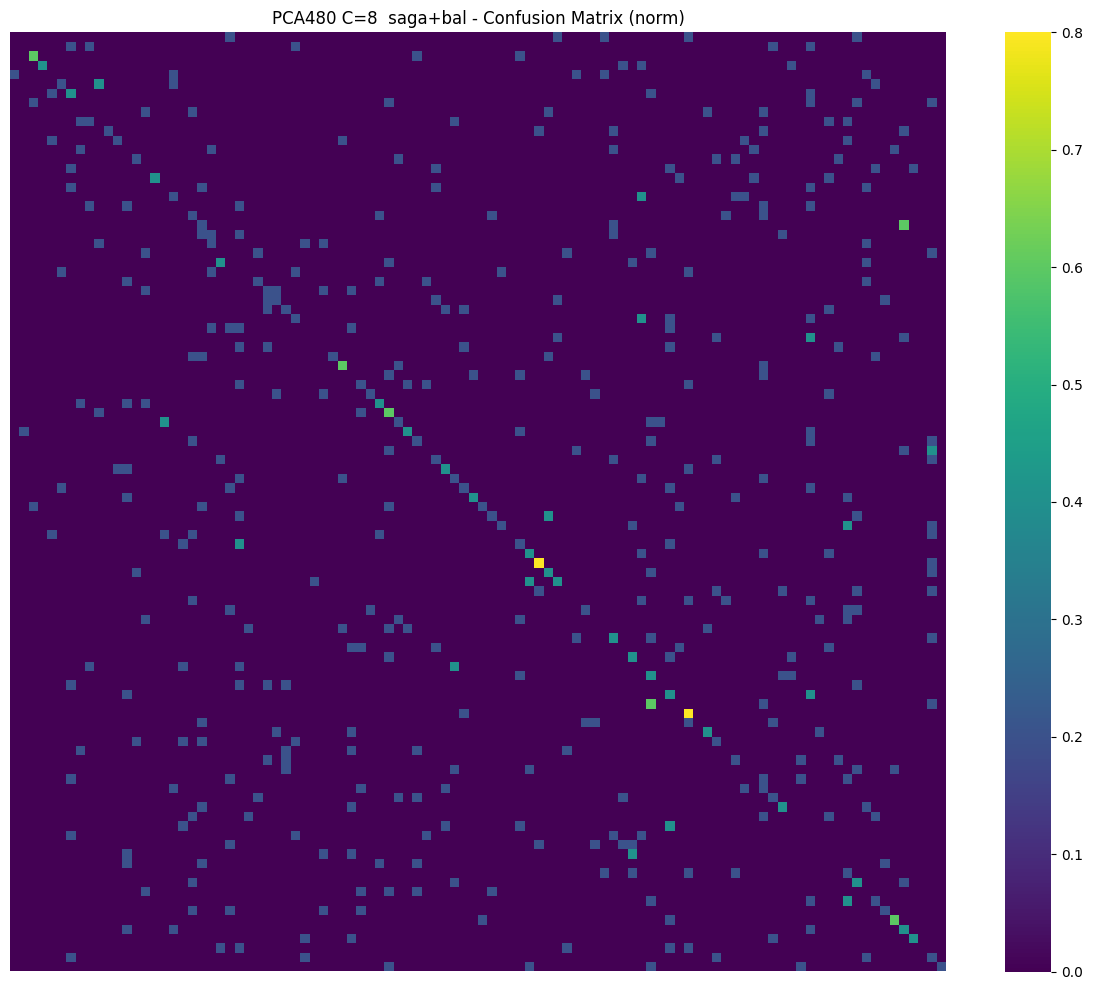


=== Top confusions: PCA480 C=8  saga+bal ===

Top 30 coppie più confuse:

chuckwagon racing → water polo  | 3 errori
rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
bungee jumping → rock climbing  | 2 errori
disc golf → croquet  | 2 errori
fly fishing → rock climbing  | 2 errori
formula 1 racing → swimming  | 2 errori
hockey → bull riding  | 2 errori
horseshoe pitching → wheelchair racing  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
log rolling → disc golf  | 2 errori
nascar racing → luge  | 2 errori
rock climbing → ice climbing  | 2 errori
rowing → swimming  | 2 errori
surfing → rowing  | 2 errori
tennis → rings  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → curling  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute football → basketball  | 1 errori
ampute foo

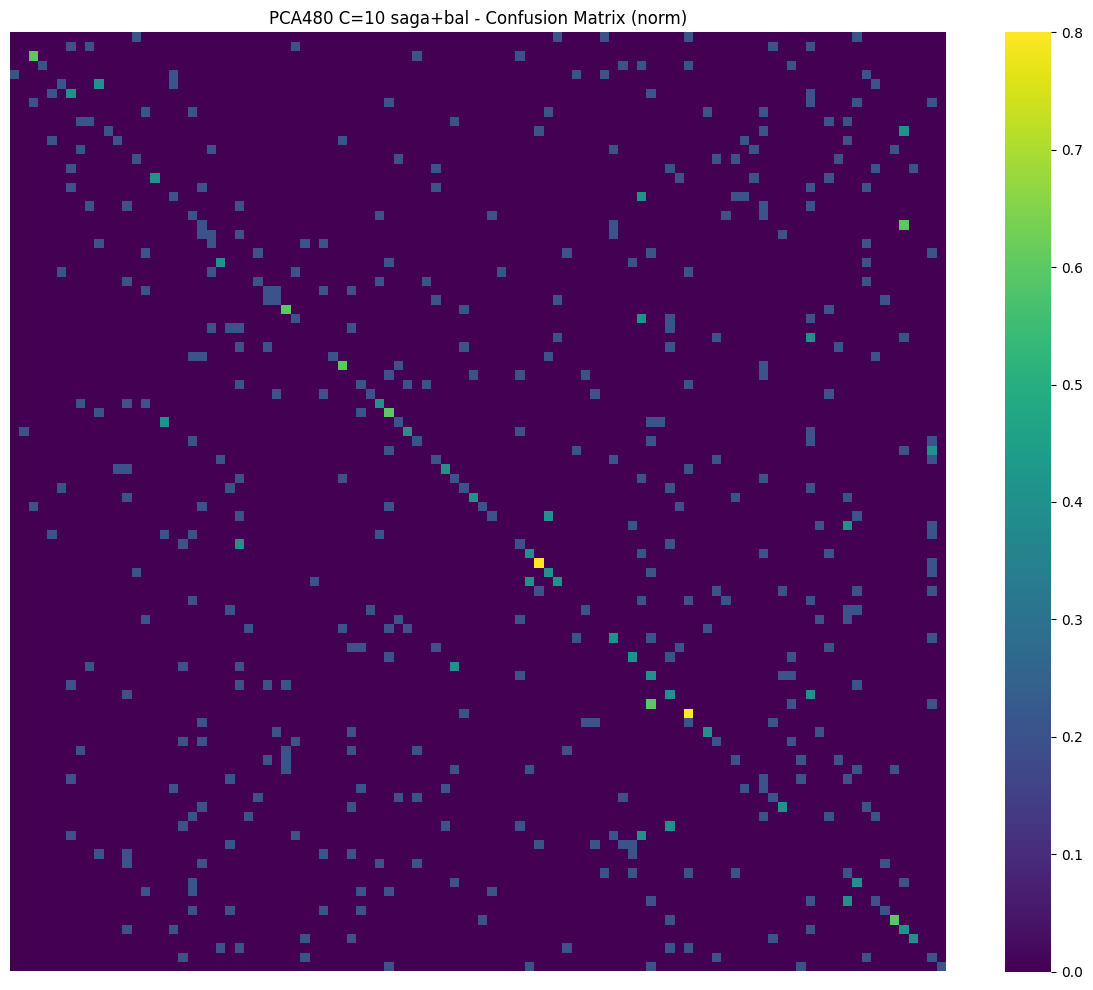


=== Top confusions: PCA480 C=10 saga+bal ===

Top 30 coppie più confuse:

chuckwagon racing → water polo  | 3 errori
rugby → roller derby  | 3 errori
balance beam → baton twirling  | 2 errori
bike polo → water polo  | 2 errori
bungee jumping → rock climbing  | 2 errori
disc golf → croquet  | 2 errori
fly fishing → rock climbing  | 2 errori
formula 1 racing → swimming  | 2 errori
hockey → bull riding  | 2 errori
horseshoe pitching → wheelchair racing  | 2 errori
jousting → mushing  | 2 errori
judo → trapeze  | 2 errori
log rolling → disc golf  | 2 errori
nascar racing → luge  | 2 errori
rock climbing → ice climbing  | 2 errori
rowing → swimming  | 2 errori
surfing → rowing  | 2 errori
swimming → rock climbing  | 2 errori
uneven bars → trapeze  | 2 errori
air hockey → bobsled  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → pole vault  | 1 errori
air hockey → sailboat racing  | 1 errori
air hockey → tug of war  | 1 errori
ampute football → barell racing  | 1 errori
ampute

In [11]:
for tag, cm in cms.items():
    plot_cm(cm, title=f"{tag} - Confusion Matrix (norm)")
    print(f"\n=== Top confusions: {tag} ===")
    print_top_confusions(cm, class_names, top_k=30)

In [12]:
print("\n" + "="*60)
print("FINAL SUMMARY (SPATIAL PYRAMID)")
print("="*60)

for tag, data in all_results.items():
    print(f"{tag:30} | Acc={data['acc']:.4f} | F1={data['f1']:.4f} | C={data['C']}")


FINAL SUMMARY (SPATIAL PYRAMID)
PCA480 C=8  lbfgs              | Acc=0.1940 | F1=0.1876 | C=8.0
PCA480 C=8  saga               | Acc=0.1860 | F1=0.1804 | C=8.0
PCA480 C=8  saga+bal           | Acc=0.1860 | F1=0.1809 | C=8.0
PCA480 C=10 saga+bal           | Acc=0.1860 | F1=0.1798 | C=10.0
